# Семинар 11: Деревья решений. Ансамбль моделей: бэггинг (bagging = bootstrap aggregating), случайный лес (random forest) и бустинг (boosting)

In [196]:
%matplotlib inline
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import seaborn as sns; sns.set()

from ipywidgets import interact

In [197]:
random_seed = 42

In [198]:
def visualize_tree(estimator, X, y, boundaries=True, xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='rainbow', clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap='rainbow', clim=(y.min(), y.max()), zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)

def plot_tree_interactive(X, y):
    def interactive_tree(depth=7):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)
    return interact(interactive_tree, depth=[1, 2, 3, 4, 5, 6, 7])

def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        rng = np.random.RandomState(random_state)
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False, xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 25, 50, 75, 100]);

def visualize_classifier(model, X, y, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='rainbow', clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap='rainbow', clim=(y.min(), y.max()), zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
        
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap='rainbow')
    if contour:
        plt.contour(x1, x2, y_pred, alpha=0.8, cmap='rainbow')
       
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

## Дерево решений

Дерево решений состоит из набора вложенных правил принятия решений. В каждом узле ``i`` компонента ``d_i`` входного вектора ``x`` сравнивается с пороговым значением ``t_i``, после чего входной вектор передается в левую или правую ветвь, в зависимости от того, выше или ниже. В листьях дерева модель задает прогнозируемый выход для любого входа, который попадает в эту ветвь.

Рассмотрим следующие двумерные данные, где каждая точка принадлежит одному из четырех классов.

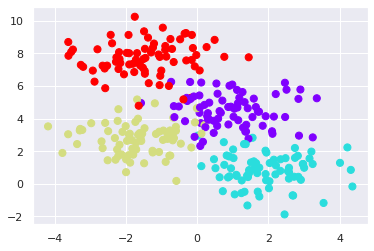

In [199]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], cmap='rainbow', c=y, s=50);

Простое дерево принятия решений для этих данных будет многократно разделять
данные по одной или нескольким осям, в соответствии с определенным количественным критерием, и на каждом уровне маркировать новую область согласно большинству лежащих в ней точек.

![](images/05.08-decision-tree-levels.png)

Процесс обучения дерева принятия решений на наших данных можно выполнить в Scikit-Learn посредством ``DecisionTreeClassifier``.

In [200]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(X, y)

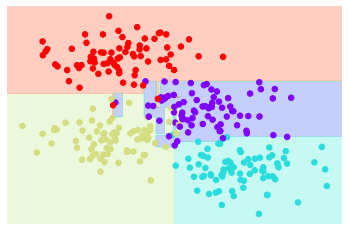

In [201]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [202]:
plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=6, options=(1, 2, 3, 4, 5, 6, 7), value=7), Output()…

### Деревья решений и переобучение

По мере возрастания глубины мы получаем области классификации очень странной формы. 
Такая конфигурация является скорее не результатом собственно распределения данных, а конкретной их дискретизации или свойств шума в них.
Дерево принятия решений на достаточной глубине уже очевидным образом переобучено.

Другой способ столкнуться с переобучением — обучить пару моделей на различных подмножествах набора данных.

![](images/05.08-decision-tree-overfitting.png)

В некоторых областях результаты двух деревьев не противоречат друг другу, а в других областях их классификации очень
сильно различаются (например, в областях между любыми двумя кластерами).
Расхождения имеют тенденцию появляться в тех местах, где степень достоверности классификации ниже, а значит, мы можем
добиться лучшего результата, используя информацию из обоих деревьев!

Рассмотрим деревья решений, обученные на случайных подмножествах исходного набора данных.

In [203]:
randomized_tree_interactive(X, y);

interactive(children=(Dropdown(description='random_state', options=(0, 25, 50, 75, 100), value=0), Output()), …

### Общие принципы построения дерева для задачи классификации и регрессии

In [204]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz
import graphviz

Найти оптимальное разбиение данных Функция разбиения должна выбирать `лучший` признак и `лучшее` пороговое значение признака:

$$
(j^{\star},t^{\star}) = \arg \underset{j \in \{1,...,D\}}{\min} \underset{t \in \mathrm{T}_j}{\min} \Big( cost(\{x_i,y_i : x_{i,j} \leq t\}) + cost(\{x_i,y_i : x_{i,j} > t\}) \Big)
$$


### Задача классификации

В чем состоит задача классификации? Какую функцию стоимости `cost` будем оптимизировать? 

$$
\tilde{\pi}_{c} = \frac{1}{|L|} \sum_{i \in L} \mathbb{I}(y_i=c)
$$

- Gini $$ cost = \mathbb{G}( \tilde{\pi}_{c} ) = \sum_{c=1}^{C} \tilde{\pi}_{c} (1 - \tilde{\pi}_{c}) = 1 - \sum_{c=1}^{C} \tilde{\pi}_{c}^2 $$
- Entropy $$cost = \mathbb{H}( \tilde{\pi}_{c} ) = - \sum_{c=1}^{C} \tilde{\pi}_{c} \log \tilde{\pi}_{c} $$
- LogLoss $$cost = \mathbb{L}( \pi_c ) = -\sum_{c=1}^{C} y_c {\log} \pi_c $$

In [205]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

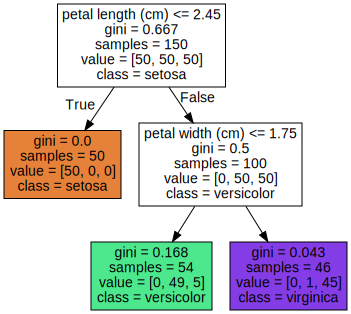

In [206]:
export_graphviz(tree_clf, out_file="classification_tree.dot", feature_names=iris.feature_names[2:], class_names=iris.target_names, filled=True)

with open("classification_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

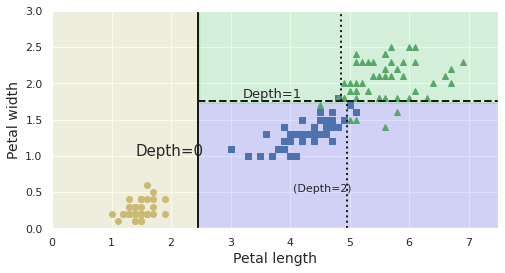

In [207]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)
plt.show()

### Задача регрессии

Какая функция стоимости?
$$
cost(\mathcal{D}) = \sum_{i \in \mathcal{D}} (y - \tilde{y})^2
$$

In [208]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [209]:
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

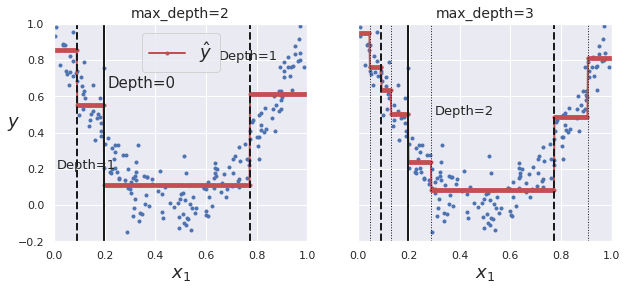

In [210]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

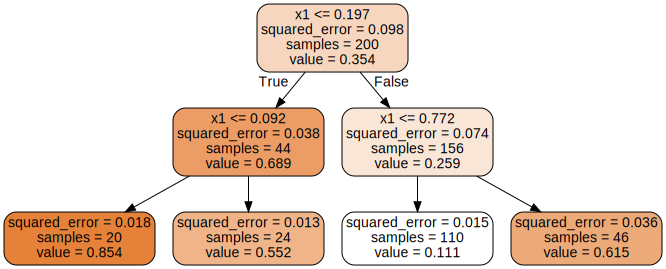

In [211]:
export_graphviz(
 tree_reg1,
 out_file="regression_tree.dot",
 feature_names=["x1"],
 rounded=True,
 filled=True
)

with open("regression_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

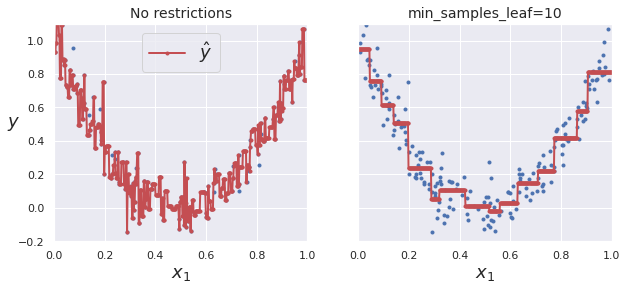

In [212]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

### Преимущества и недостатки деревьеа

Преимущества
- Модель легко интерпретируемая.
- Модель обрабатывает, как непрерывные данные, так и дискретные (категорийные).
- Модель не чувствительна к монотонным преобразованиям входных данных
- Модель устойчива к выборосам

Недостатки
- Модель не обладает высокой точностью в сравнении с другими моделями
- Модель при небольших изменениях может значительно поменять свою структуру

## Ансамбль моделей: бэггинг (bagging = bootstrap aggregating)

Метод построения ансамбля моделей, при котором базовые модели обучаются независимо на различных случайных подвыборках исходного набора данных.

Выполнить подобную бэггинг-классификацию можно вручную с помощью метаоценивателя ``sklearn.ensemble.BaggingClassifier`` из библиотеки Scikit-Learn.

### Задача классификации

In [213]:
from sklearn.model_selection import train_test_split
from sklearn.datasets        import load_iris
from sklearn.metrics         import accuracy_score

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

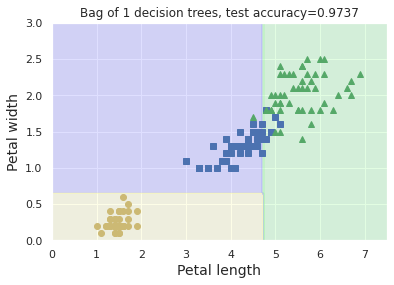

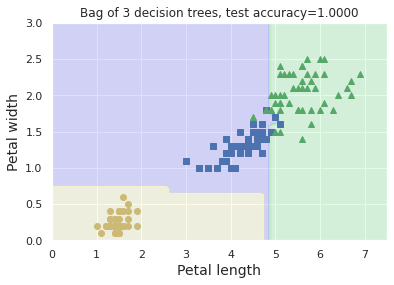

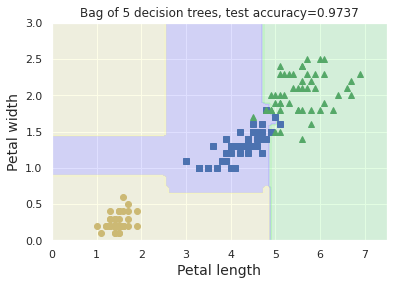

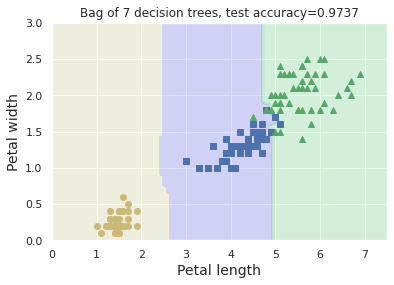

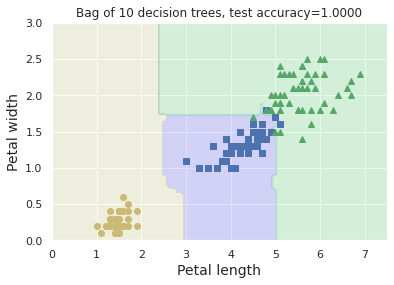

In [214]:
bag_sizes = [1, 3, 5, 7, 10]
for bag_size in bag_sizes:
    bag_clf = BaggingClassifier( DecisionTreeClassifier(random_state=42), n_estimators=bag_size, max_samples=30, bootstrap=True, random_state=42 )
    bag_clf.fit(X_train, y_train)
    y_pred = bag_clf.predict(X_test)
    bag_acc = accuracy_score(y_test, y_pred)

    plt.figure()
    plot_decision_boundary(bag_clf, X, y)
    plt.title("Bag of {} decision trees, test accuracy={:0.4f}".format(bag_size, bag_acc))

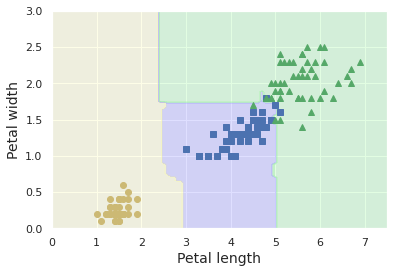

In [215]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree     import DecisionTreeClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=42)

bag.fit(X, y)
#visualize_classifier(bag, X, y)
plot_decision_boundary(bag_clf, X, y)

## Ансамбль моделей: случайный лес (random forest)



Метод построения ансамбля моделей, при котором базовые модели обучаются независимо на различных случайных подвыборках исходного набора данных. Что еще можно использовать?

В библиотеке Scikit-Learn есть отдельная модель ``sklearn.ensemble.RandomForestClassifier``.

1.0


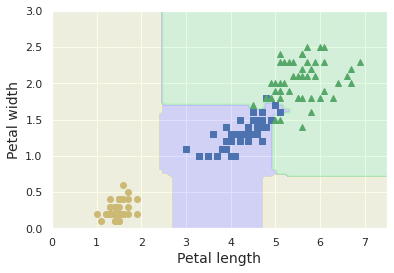

In [216]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
plot_decision_boundary(rnd_clf, X, y)

print(accuracy_score(y_test, y_pred_rf))

1.0


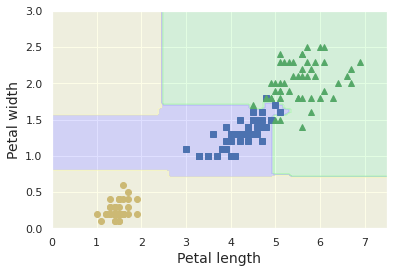

In [217]:
bag_clf = BaggingClassifier(
 DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
 n_estimators=500, random_state=42
)

bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

plot_decision_boundary(bag_clf, X, y)
print(accuracy_score(y_test, y_pred_bag))

### Важность признаков
Как мы оценивали взаимосвзяь между признаками?


In [218]:
from sklearn.datasets import load_iris

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


## Ансамбль моделей: бустинг (boosting)

Метод построения ансамбля моделей, при котором базовые модели обучаются последовательно и каждая последующая модель ансамбля применяется к результатам на выходе предыдущей.

Таким образом, метод бустинга реализует последовательную композицию алгоритмов обучения, в которой каждый алгоритм должен компенсировать ошибки, допущенные композицией предыдущих алгоритмов.

### Задача регрессии

In [219]:
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

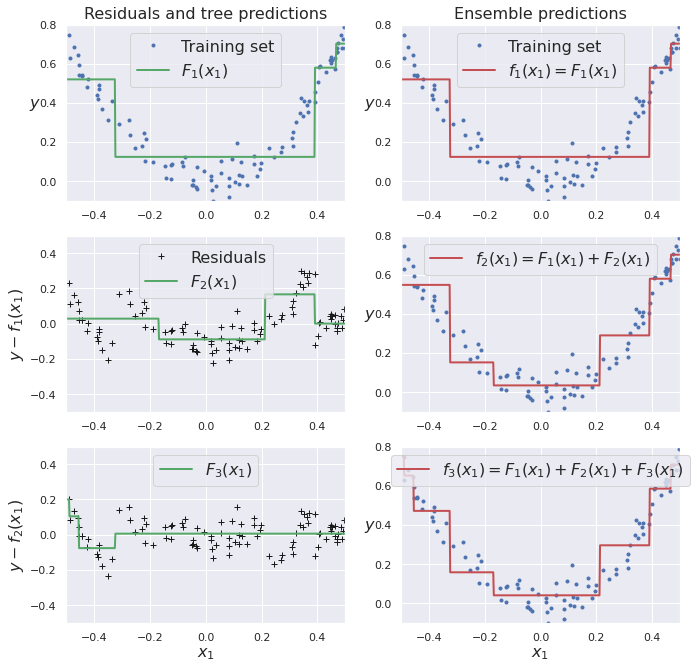

In [220]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$F_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$f_1(x_1) = F_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5],
                 label="$F_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - f_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$f_2(x_1) = F_1(x_1) + F_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], 
                 label="$F_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - f_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, 
                 axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$f_3(x_1) = F_1(x_1) + F_2(x_1) + F_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

***GradientBoostingRegressor***

In [221]:
from sklearn.ensemble import GradientBoostingRegressor

In [222]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [223]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Ансамбли GradientBoostingRegressor с недостаточным (слева) и избыточным (справа) количеством предикторов

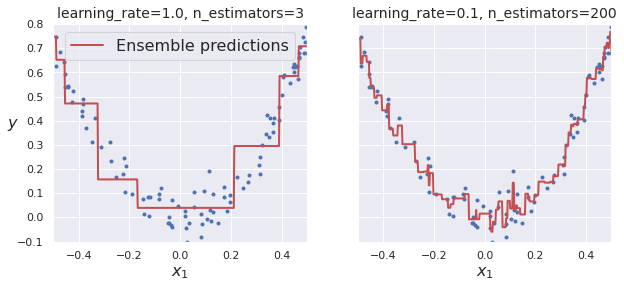

In [224]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

**GradientBoostingRegressor с ранней остановкой**

Настройка количества деревьев с помощью ранней остановки

In [225]:
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=51, random_state=42)

In [226]:
min_val_error = np.min(errors)
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.0025511875195462896


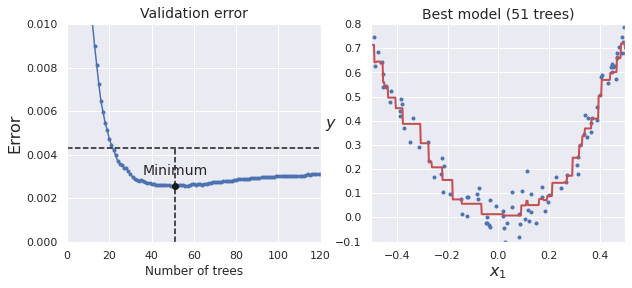

In [227]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_val_error, "ko")
plt.text(bst_n_estimators, min_val_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)


plt.show()

Ранняя остановка, где прерывается обучение только после отсутствия улучшений в течение 5 эпох

In [228]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [229]:
print(gbrt.n_estimators)

56


In [230]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.0025511875195462896


**XGBoost**

In [231]:
import xgboost

In [232]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

Validation MSE: 0.0045108418445291044


In [233]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=5)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)  
print("Validation MSE:", val_error)            

[0]	validation_0-rmse:0.23025
[1]	validation_0-rmse:0.17344
[2]	validation_0-rmse:0.13290
[3]	validation_0-rmse:0.10571
[4]	validation_0-rmse:0.08555
[5]	validation_0-rmse:0.07426
[6]	validation_0-rmse:0.06595
[7]	validation_0-rmse:0.06095
[8]	validation_0-rmse:0.05891
[9]	validation_0-rmse:0.05749
[10]	validation_0-rmse:0.05803
[11]	validation_0-rmse:0.05877
[12]	validation_0-rmse:0.05938
[13]	validation_0-rmse:0.05996
Validation MSE: 0.0033050627159747535


### Задача классификации

In [234]:
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

[0]	validation_0-mlogloss:0.72865
[1]	validation_0-mlogloss:0.51363
[2]	validation_0-mlogloss:0.37261
[3]	validation_0-mlogloss:0.27697
[4]	validation_0-mlogloss:0.20950
[5]	validation_0-mlogloss:0.15859
[6]	validation_0-mlogloss:0.12233
[7]	validation_0-mlogloss:0.09586
[8]	validation_0-mlogloss:0.07696
[9]	validation_0-mlogloss:0.06245
[10]	validation_0-mlogloss:0.05216
[11]	validation_0-mlogloss:0.04505
[12]	validation_0-mlogloss:0.03705
[13]	validation_0-mlogloss:0.03174
[14]	validation_0-mlogloss:0.02719
[15]	validation_0-mlogloss:0.02396
[16]	validation_0-mlogloss:0.02132
[17]	validation_0-mlogloss:0.01948
[18]	validation_0-mlogloss:0.01816
[19]	validation_0-mlogloss:0.01698
[20]	validation_0-mlogloss:0.01635
[21]	validation_0-mlogloss:0.01617
[22]	validation_0-mlogloss:0.01561
[23]	validation_0-mlogloss:0.01538
[24]	validation_0-mlogloss:0.01488
[25]	validation_0-mlogloss:0.01459
[26]	validation_0-mlogloss:0.01431
[27]	validation_0-mlogloss:0.01407
[28]	validation_0-mlogloss:0.0

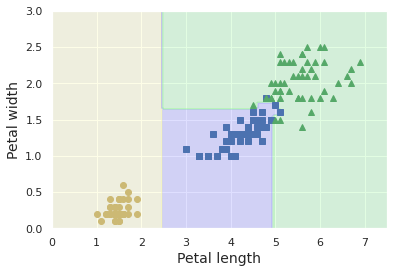

In [235]:
xgb_clf = xgboost.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=2)
y_pred = xgb_clf.predict(X_test)
plot_decision_boundary(xgb_clf, X, y)

### Важность признаков

In [236]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [237]:
xgb_clf = xgboost.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=2)
y_pred = xgb_clf.predict(X_test)

xgb_clf.get_booster().get_score(importance_type="gain")

[0]	validation_0-mlogloss:0.72729
[1]	validation_0-mlogloss:0.50975
[2]	validation_0-mlogloss:0.36852
[3]	validation_0-mlogloss:0.27269
[4]	validation_0-mlogloss:0.20777
[5]	validation_0-mlogloss:0.16104
[6]	validation_0-mlogloss:0.12619
[7]	validation_0-mlogloss:0.09944
[8]	validation_0-mlogloss:0.07951
[9]	validation_0-mlogloss:0.06674
[10]	validation_0-mlogloss:0.05628
[11]	validation_0-mlogloss:0.04829
[12]	validation_0-mlogloss:0.04113
[13]	validation_0-mlogloss:0.03662
[14]	validation_0-mlogloss:0.03200
[15]	validation_0-mlogloss:0.02838
[16]	validation_0-mlogloss:0.02615
[17]	validation_0-mlogloss:0.02498
[18]	validation_0-mlogloss:0.02279
[19]	validation_0-mlogloss:0.02126
[20]	validation_0-mlogloss:0.02055
[21]	validation_0-mlogloss:0.01990
[22]	validation_0-mlogloss:0.01897
[23]	validation_0-mlogloss:0.01855
[24]	validation_0-mlogloss:0.01821
[25]	validation_0-mlogloss:0.01834
[26]	validation_0-mlogloss:0.01771
[27]	validation_0-mlogloss:0.01774
[28]	validation_0-mlogloss:0.0

{'f0': 0.04686770960688591,
 'f1': 0.14760874211788177,
 'f2': 2.605591058731079,
 'f3': 0.8505897521972656}

### Бонус. Практический пример Email Spam

Данные для этого практического примера состоят из информации о 4601 электронных сообщении (e-mail messages).
Задача состояла в том, чтобы разработать автоматический детектор спама, который мог бы отфильтровывать спам до того, как он засорит почтовые ящики пользователей. 
Для всех сообщения электронной почты имеется информация об истинном результате (тип письма) - письмо или спам, задача классификации (логистическая регрессия).

**Информация о данных.** Общее число : 4601 (1813 Spam = 39.4%). Общее число признаков: 58 (57 непрерывных, 1 метка класса).

Признаки:

|                          |                                                                                                       |
|--------------------------|-------------------------------------------------------------------------------------------------------|
|test                      |обозначает, является ли данная запись обучающей (0) или тестовой (1)                                   |
|word_freq_WORD            |процент слов в письме, которые совпадают WORD,<br>continuous real [0,100]                              |
|char_freq_CHAR            |процент символов в письме, которые совпадают CHAR,<br>continuous real [0,100]                          |
|capital_run_length_average|средняя длина непрерывных последовательностей заглавных букв,<br>continuous real [1,...]               |
|capital_run_length_longest|длина самой длинной непрерывной последовательности заглавных букв,<br>continuous integer [1,...]       |
|capital_run_length_total  |сумма длин непрерывных последовательностей заглавных букв,<br>continuous integer [1,...]               |
|spam                      |обозначает, было ли письмо признано спамом (1) или нет (0),<br>т.е. нежелательная коммерческая рассылка|

In [238]:
import statsmodels.api as sm
import numpy           as np
import pandas          as pd

# Performance of tree ensembles. Based on the email spam example from chapter 10 of "Elements of statistical learning". Code is from Andrey Gaskov's site:
# https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/examples/Spam.ipynb
# Commented out IPython magic to ensure Python compatibility.

from matplotlib      import transforms, pyplot as plt
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.ensemble     import BaggingClassifier
from catboost             import CatBoostClassifier, Pool, cv

# omit numpy warnings (don't do it in real work)
np.seterr(divide="ignore", invalid="ignore")
np.warnings.filterwarnings("ignore")
# %matplotlib inline

# define plots common properties and color constants
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.linewidth"] = 0.5
ORANGE, BLUE, PURPLE = "#FF8C00", "#0000FF", "#A020F0"
GRAY1, GRAY4, GRAY7 = "#231F20", "#646369", "#929497"


# we will calculate train and test error rates for all models
def error_rate(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

"""Get data"""

df = pd.read_csv(
    "https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/data/Spam.txt?raw=True"
)
df.head(n = 10)



# PAGE 301. We coded spam as 1 and email as zero. A test set of size 1536 was
#           randomly chosen, leaving 3065 observations in the training set.
target = "spam"
columns = [
    "word_freq_make",
    "word_freq_address",
    "word_freq_all",
    "word_freq_3d",
    "word_freq_our",
    "word_freq_over",
    "word_freq_remove",
    "word_freq_internet",
    "word_freq_order",
    "word_freq_mail",
    "word_freq_receive",
    "word_freq_will",
    "word_freq_people",
    "word_freq_report",
    "word_freq_addresses",
    "word_freq_free",
    "word_freq_business",
    "word_freq_email",
    "word_freq_you",
    "word_freq_credit",
    "word_freq_your",
    "word_freq_font",
    "word_freq_000",
    "word_freq_money",
    "word_freq_hp",
    "word_freq_hpl",
    "word_freq_george",
    "word_freq_650",
    "word_freq_lab",
    "word_freq_labs",
    "word_freq_telnet",
    "word_freq_857",
    "word_freq_data",
    "word_freq_415",
    "word_freq_85",
    "word_freq_technology",
    "word_freq_1999",
    "word_freq_parts",
    "word_freq_pm",
    "word_freq_direct",
    "word_freq_cs",
    "word_freq_meeting",
    "word_freq_original",
    "word_freq_project",
    "word_freq_re",
    "word_freq_edu",
    "word_freq_table",
    "word_freq_conference",
    "char_freq_;",
    "char_freq_(",
    "char_freq_[",
    "char_freq_!",
    "char_freq_$",
    "char_freq_#",
    "capital_run_length_average",
    "capital_run_length_longest",
    "capital_run_length_total",
]
# let's give columns more compact names
features = [
    "make",
    "address",
    "all",
    "3d",
    "our",
    "over",
    "remove",
    "internet",
    "order",
    "mail",
    "receive",
    "will",
    "people",
    "report",
    "addresses",
    "free",
    "business",
    "email",
    "you",
    "credit",
    "your",
    "font",
    "000",
    "money",
    "hp",
    "hpl",
    "george",
    "650",
    "lab",
    "labs",
    "telnet",
    "857",
    "data",
    "415",
    "85",
    "technology",
    "1999",
    "parts",
    "pm",
    "direct",
    "cs",
    "meeting",
    "original",
    "project",
    "re",
    "edu",
    "table",
    "conference",
    "ch_;",
    "ch(",
    "ch[",
    "ch!",
    "ch$",
    "ch#",
    "CAPAVE",
    "CAPMAX",
    "CAPTOT",
]

X, y = df[columns].values, df[target].values

# Переделать под кросс валидацию
# split by test column value
is_test = df.test.values
X_train, X_test = X[is_test == 0], X[is_test == 1]
y_train, y_test = y[is_test == 0], y[is_test == 1]

""" Logistic regression

As a sanity check, we try to match p301  test error rate of 7.6%.

"""
lr_clf = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=False)
# 0.5 is a threshold
y_test_hat = (lr_clf.predict(sm.add_constant(X_test)) > 0.5).astype(int)
lr_error_rate = error_rate(y_test, y_test_hat)
print(f"Logistic Regression Test Error Rate: {lr_error_rate*100:.1f}%")

# PAGE 590. A random forest classifier achieves 4.88% misclassification error
#           on the spam test data, which compares well with all other methods,
#           and is not significantly worse than gradient boosting at 4.5%.
ntrees_list = [10, 50, 100, 200, 300, 400, 500]

bag_errors = []
for ntrees in ntrees_list:
    bag_clf = BaggingClassifier(n_estimators=ntrees, random_state=10, bootstrap=True).fit(X_train, y_train)
    y_test_hat = bag_clf.predict(X_test)
    bag_error_rate = error_rate(y_test, y_test_hat)
    bag_errors.append(bag_error_rate)
    print(f"Bagged {ntrees} trees, test error {bag_error_rate*100:.1f}%")

rf_errors = []
for ntrees in ntrees_list:
    rf_clf = RandomForestClassifier(n_estimators=ntrees, random_state=10).fit(X_train, y_train)
    y_test_hat = rf_clf.predict(X_test)
    rf_error_rate = error_rate(y_test, y_test_hat)
    rf_errors.append(rf_error_rate)
    print(f"RF {ntrees} trees, test error {rf_error_rate*100:.1f}%")

boost_errors = []
for ntrees in ntrees_list:
    boost_clf = CatBoostClassifier(iterations=ntrees, random_state=10, learning_rate=0.2, verbose=False).fit(
        X_train, y_train
    )
    y_test_hat = boost_clf.predict(X_test)
    boost_error_rate = error_rate(y_test, y_test_hat)
    boost_errors.append(boost_error_rate)
    print(f"Boosting {ntrees} trees, test error {boost_error_rate*100:.1f}%")

Logistic Regression Test Error Rate: 7.6%
Bagged 10 trees, test error 5.9%
Bagged 50 trees, test error 5.5%
Bagged 100 trees, test error 5.4%
Bagged 200 trees, test error 5.5%
Bagged 300 trees, test error 5.5%
Bagged 400 trees, test error 5.4%
Bagged 500 trees, test error 5.6%
RF 10 trees, test error 6.3%
RF 50 trees, test error 5.0%
RF 100 trees, test error 4.9%
RF 200 trees, test error 4.8%
RF 300 trees, test error 4.9%
RF 400 trees, test error 4.8%
RF 500 trees, test error 4.8%
Boosting 10 trees, test error 6.2%
Boosting 50 trees, test error 5.4%
Boosting 100 trees, test error 4.7%
Boosting 200 trees, test error 4.6%
Boosting 300 trees, test error 4.8%
Boosting 400 trees, test error 4.6%
Boosting 500 trees, test error 4.4%


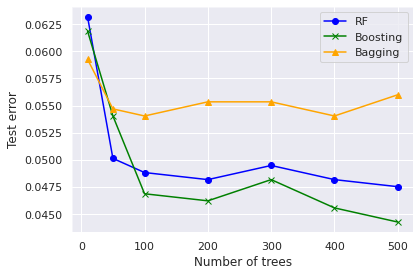

In [239]:
plt.figure()
plt.plot(ntrees_list, rf_errors   , "o-", color="blue"  , label="RF"      )
plt.plot(ntrees_list, boost_errors, "x-", color="green" , label="Boosting")
plt.plot(ntrees_list, bag_errors  , "^-", color="orange", label="Bagging" )
plt.legend()
plt.xlabel("Number of trees")
plt.ylabel("Test error")
plt.tight_layout()